In [ ]:
!pip install sentencepiece
!pip install tensorboardX
!pip install utils
!pip install git+https://github.com/NVIDIA/apex
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 19.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 10.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/NVIDIA/apex to /tmp/pip-req-build-psg889pl
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-psg889pl
  Running command git submodule update --init --recursive -q
  Created wheel for apex: filename=apex-0.1-py3-none-any.whl size=346506 sha256=906b2b569b601fbced5d8b7efc851735d13ccccaf39173c8cdc502cdf5b2c4de
  Stored in directory: /tmp/pip-ephem-wheel-cache-307ep3ft/wheels/dd/7b/dc/dc522332f3f6f60db5440cbcc4ee70aa155c2cf7d1f15

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 15.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d6d14aca7505fa822243aafcfa0409eda82b46e84e495443f64988b8fba676cb
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [ ]:
from __future__ import absolute_import, division, print_function

In [ ]:
import csv
import logging
import sys
from io import open
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn import preprocessing
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import matthews_corrcoef, f1_score
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from tqdm import tqdm_notebook, trange
import glob
from collections import Counter
import os
import gc
import re
import random
import json
import numpy as np
import torch
import os
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
from transformers import AdamW,get_linear_schedule_with_warmup
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix
from scipy.stats import pearsonr
from torch.utils.tensorboard import SummaryWriter
import subprocess, torch
from torch.utils.cpp_extension import CUDAExtension
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from sklearn.metrics import classification_report
import scikitplot as skplt
import seaborn as sns

nltk.download('stopwords')
cuda_dir = torch.utils.cpp_extension.CUDA_HOME
print(subprocess.check_output([cuda_dir + "/bin/nvcc", "-V"]))

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

logger = logging.getLogger(__name__)
csv.field_size_limit(sys.maxsize)

%matplotlib inline

b'nvcc: NVIDIA (R) Cuda compiler driver\nCopyright (c) 2005-2021 NVIDIA Corporation\nBuilt on Sun_Feb_14_21:12:58_PST_2021\nCuda compilation tools, release 11.2, V11.2.152\nBuild cuda_11.2.r11.2/compiler.29618528_0\n'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
df = pd.read_csv('IPD_Reddit_Dataset.csv')

In [ ]:
df.head()

,text,depression
0,I love him,0
1,I got accepted into a Graduate program I wante...,0
2,our film production professor gave us our midt...,0
3,Just got done speaking with the inspector for ...,0
4,so i'm nonbinary and despite knowing that most...,0


In [ ]:
df['depression'].value_counts()

1    3937
0     801
Name: depression, dtype: int64

In [ ]:
df.isna().sum()

text          0
depression    0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
words_dep = []
for sp in list(df.query('depression == 1')['text']):
  words = [word for word in sp.split() if word not in set(stopwords.words('english'))]
  words_dep += words
counter_dep = Counter(words_dep)

top_10_dep = counter_dep.most_common(10)

x_dep = [ cnt[0] for cnt in top_10_dep]
y_dep = [ cnt[1] for cnt in top_10_dep]

words_nor = []
for sp in list(df.query('depression == 0')['text']):
  words = [word for word in sp.split() if word not in set(stopwords.words('english'))]
  words_nor += words
counter_nor = Counter(words_nor)

top_10_nor = counter_nor.most_common(10)

x_nor = [ cnt[0] for cnt in top_10_nor]
y_nor = [ cnt[1] for cnt in top_10_nor]

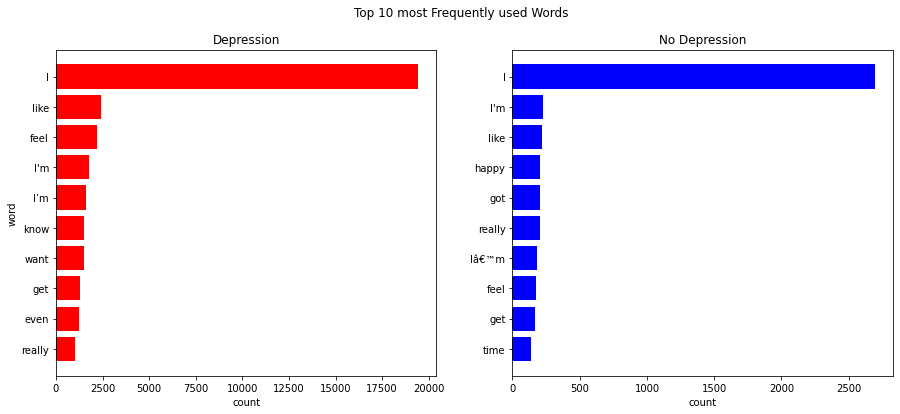

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].barh(x_dep[::-1],y_dep[::-1],color='r')
axs[0].set_title('Depression')
axs[0].set_xlabel('count')
axs[0].set_ylabel('word')

axs[1].barh(x_nor[::-1],y_nor[::-1],color='b')
axs[1].set_title('No Depression')
axs[1].set_xlabel('count')

plt.suptitle('Top 10 most Frequently used Words');

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['depression'], 
                                                test_size=0.20, random_state=42)

In [ ]:
y_train.value_counts()/len(y_train)

1    0.835092
0    0.164908
Name: depression, dtype: float64

In [ ]:
y_test.value_counts()/len(y_test)

1    0.814346
0    0.185654
Name: depression, dtype: float64

In [ ]:
train_df = pd.DataFrame({
    'id':range(len(X_train)),
    'label':y_train,
    'alpha':['a']*X_train.shape[0],
    'text': X_train.replace(r'\n', ' ', regex=True)
})

train_df.head()

,id,label,alpha,text
759,0,0,a,I feel like I've won the lottery of life
3844,1,1,a,Before you answer let me tell you a little abo...
2486,2,1,a,Living is just playing pretend to me
3347,3,1,a,My uncle told my cousins to stay away from me ...
4693,4,1,a,I ended the relationship with my boyfriend a m...


In [ ]:
dev_df = pd.DataFrame({
    'id':range(len(X_test)),
    'label':y_test,
    'alpha':['a']*X_test.shape[0],
    'text': X_test.replace(r'\n', ' ', regex=True)
})

dev_df.head()

,id,label,alpha,text
2312,0,1,a,I feel like trash today
354,1,0,a,"I have been feeling down all day, a feeling I ..."
1397,2,1,a,I have friends but I feel like nobody cares
1714,3,1,a,Vent
3935,4,1,a,I am 16 and already want to end my life... It...


In [ ]:
train_df.to_csv('/content/data/train.tsv', sep='\t', index=False, header=False)
dev_df.to_csv('/content/data/dev.tsv', sep='\t', index=False, header=False)

In [ ]:
del(X_train) 
del(X_test)
del(y_train) 
del(y_test)
del(df)
del(train_df)
del(dev_df)

gc.collect()

26

## XLNET

In [ ]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [ ]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines

In [ ]:
class BinaryProcessor(DataProcessor):
    """Processor for the binary data sets"""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
            """Creates examples for the training and dev sets."""
            examples = []
            j = 0
            k=0
            for (i, line) in enumerate(lines):
                try:
                  guid = "%s-%s" % (set_type, i)
                  text_a = line[3]
                  label = line[1]
                  examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
                  k +=1
                except Exception as e:
                  j += 1
            print(j)
            print(k)
            return examples

In [ ]:
def convert_example_to_feature(example_row, pad_token=0,
sequence_a_segment_id=0, sequence_b_segment_id=1,
cls_token_segment_id=1, pad_token_segment_id=0,
mask_padding_with_zero=True):
    example, label_map, max_seq_length, tokenizer, output_mode, cls_token_at_end, cls_token, sep_token, cls_token_segment_id, pad_on_left, pad_token_segment_id = example_row

    tokens_a = tokenizer.tokenize(example.text_a)

    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    else:
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids:   0   0   0   0  0     0   0
    #
    # Where "type_ids" are used to indicate whether this is the first
    # sequence or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). This is not *strictly* necessary
    # since the [SEP] token unambiguously separates the sequences, but it makes
    # it easier for the model to learn the concept of sequences.
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as as the "sentence vector". Note that this only makes sense because
    # the entire model is fine-tuned.
    tokens = tokens_a + [sep_token]
    segment_ids = [sequence_a_segment_id] * len(tokens)

    if tokens_b:
        tokens += tokens_b + [sep_token]
        segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

    if cls_token_at_end:
        tokens = tokens + [cls_token]
        segment_ids = segment_ids + [cls_token_segment_id]
    else:
        tokens = [cls_token] + tokens
        segment_ids = [cls_token_segment_id] + segment_ids

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = max_seq_length - len(input_ids)
    if pad_on_left:
        input_ids = ([pad_token] * padding_length) + input_ids
        input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
        segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
    else:
        input_ids = input_ids + ([pad_token] * padding_length)
        input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
        segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    if output_mode == "classification":
        label_id = label_map[example.label]
    elif output_mode == "regression":
        label_id = float(example.label)
    else:
        raise KeyError(output_mode)

    return InputFeatures(input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        label_id=label_id)

In [ ]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode,
                                 cls_token_at_end=False, pad_on_left=False,
                                 cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                 sequence_a_segment_id=0, sequence_b_segment_id=1,
                                 cls_token_segment_id=1, pad_token_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label : i for i, label in enumerate(label_list)}

    examples = [(example, label_map, max_seq_length, tokenizer, output_mode, cls_token_at_end, cls_token, sep_token, cls_token_segment_id, pad_on_left, pad_token_segment_id) for example in examples]

    process_count = cpu_count() - 1

    with Pool(process_count) as p:
        features = list(tqdm(p.imap(convert_example_to_feature, examples, chunksize=100), total=len(examples)))


    return features

In [ ]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [ ]:
processors = {
    "binary": BinaryProcessor
}

output_modes = {
    "binary": "classification"
}

GLUE_TASKS_NUM_LABELS = {
    "binary": 2
}

In [ ]:
args = {
    'data_dir': '/content/data/',
    'model_type':  'xlnet',
    'model_name': 'xlnet-base-cased',
    'task_name': 'binary',
    'output_dir': 'outputs/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': True,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 20,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Reddit Mentalhealth dataset'
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
with open('args.json', 'w') as f:
    json.dump(args, f)

In [ ]:
if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [ ]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

In [ ]:
config = config_class.from_pretrained(args['model_name'], num_labels=2, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

In [ ]:
model = model_class.from_pretrained(args['model_name'])

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model.to(device);

In [ ]:
task = args['task_name']

processor = processors[task]()
label_list = processor.get_labels()
num_labels = len(label_list)

In [ ]:
def load_and_cache_examples(task, tokenizer, evaluate=False):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = processor.get_labels()
        examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
            cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
            cls_token=tokenizer.cls_token,
            sep_token=tokenizer.sep_token,
            cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
            pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
            pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [ ]:
def train(train_dataset, model, tokenizer):
    tb_writer = SummaryWriter()
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args['warmup_steps'], num_training_steps =t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)


    return global_step, tr_loss / global_step

In [ ]:
def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds, preds_proba):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "labels":labels,
        "proba":preds_proba

    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels,preds_proba):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds, preds_proba)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, evaluate=True)
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds_proba = preds
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids, preds_proba)
    results.update(result)

    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong

In [ ]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer)
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

0
3790


100%|██████████| 3790/3790 [00:03<00:00, 1011.44it/s]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.amp is deprecated and will be removed by the end of February 2023. Use [PyTorch AMP](https://pytorch.org/docs/stable/amp.html)
  warnings.warn(msg, DeprecatedFeatureWarning)


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.895486Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:127: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0.744125Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
0.469097Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
0.371663

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


1.484886Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
0.475149

Epoch:   5%|▌         | 1/20 [02:41<51:05, 161.33s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000639

Epoch:  10%|█         | 2/20 [05:16<47:17, 157.64s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.001646

Epoch:  15%|█▌        | 3/20 [07:50<44:15, 156.22s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.001025

Epoch:  20%|██        | 4/20 [10:24<41:25, 155.32s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.239398Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
0.000543

Epoch:  25%|██▌       | 5/20 [13:00<38:48, 155.26s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000389

Epoch:  30%|███       | 6/20 [15:33<36:06, 154.72s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000368

Epoch:  35%|███▌      | 7/20 [18:07<33:28, 154.49s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.227701Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
0.000172

Epoch:  40%|████      | 8/20 [20:41<30:52, 154.40s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000148

Epoch:  45%|████▌     | 9/20 [23:18<28:25, 155.06s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.210698Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
0.000649

Epoch:  50%|█████     | 10/20 [25:52<25:48, 154.84s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000227

Epoch:  55%|█████▌    | 11/20 [28:26<23:10, 154.54s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000057

Epoch:  60%|██████    | 12/20 [31:00<20:34, 154.33s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000046

Epoch:  65%|██████▌   | 13/20 [33:35<18:01, 154.55s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000024

Epoch:  70%|███████   | 14/20 [36:09<15:25, 154.29s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000008

Epoch:  75%|███████▌  | 15/20 [38:42<12:50, 154.05s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000014

Epoch:  80%|████████  | 16/20 [41:32<10:34, 158.65s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000008

Epoch:  85%|████████▌ | 17/20 [44:21<08:05, 161.76s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000006

Epoch:  90%|█████████ | 18/20 [47:03<05:23, 161.82s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000003

Epoch:  95%|█████████▌| 19/20 [49:57<02:45, 165.64s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000005

Epoch: 100%|██████████| 20/20 [52:48<00:00, 158.42s/it]


In [ ]:
if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args['output_dir'])
    tokenizer.save_pretrained(args['output_dir'])
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

In [ ]:
results = {}
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    print("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
        result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
        results.update(result)
        

Evaluate the following checkpoints: %s ['outputs/checkpoint-2000', 'outputs/checkpoint-4000', 'outputs/checkpoint-6000', 'outputs/checkpoint-8000', 'outputs']
0
948


100%|██████████| 948/948 [00:00<00:00, 988.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:00<00:00, 974.33it/s] 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:00<00:00, 948.16it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:01<00:00, 908.98it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:00<00:00, 959.64it/s] 
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948


In [ ]:
print(classification_report(results['labels_outputs'],
                            np.argmax(results['proba_outputs'],axis=1),
                            target_names=['No Depression', 'Depression']))

               precision    recall  f1-score   support

No Depression       0.95      0.84      0.89       176
   Depression       0.96      0.99      0.98       772

     accuracy                           0.96       948
    macro avg       0.96      0.91      0.93       948
 weighted avg       0.96      0.96      0.96       948



In [ ]:
results['mcc_outputs']

0.8708803507488296

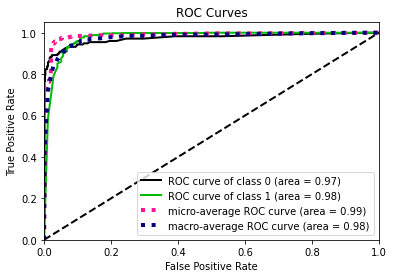

In [ ]:
skplt.metrics.plot_roc(results['labels_outputs'],results['proba_outputs'])

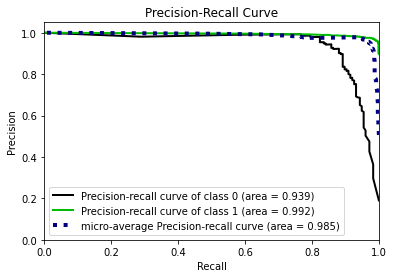

In [ ]:
skplt.metrics.plot_precision_recall(results['labels_outputs'],results['proba_outputs'])

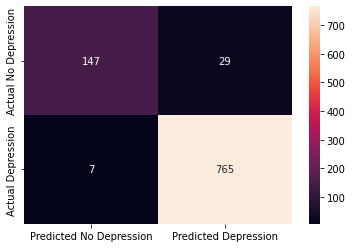

In [ ]:
cm = pd.DataFrame(data=confusion_matrix(results['labels_outputs'],
np.argmax(results['proba_outputs'],axis=1),
labels=[0,1]),
index=["Actual No Depression", "Actual Depression"],
columns=["Predicted No Depression", "Predicted Depression"])
sns.heatmap(cm,annot=True,fmt="d");

In [ ]:
import shutil
import os
shutil.rmtree('/content/outputs')
shutil.rmtree('/content/runs')
os.remove('/content/args.json')


## BERT

In [ ]:
args = {
    'data_dir': '/content/data/',
    'model_type':  'bert',
    'model_name': 'bert-base-uncased',
    'task_name': 'binary',
    'output_dir': 'outputs/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': True,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 20,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Kaggle Mentalhealth dataset'
}

with open('args.json', 'w') as f:
    json.dump(args, f)

if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [ ]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

In [ ]:
config = config_class.from_pretrained(args['model_name'], num_labels=2, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
model = model_class.from_pretrained(args['model_name'])

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.to(device);

In [ ]:
task = args['task_name']

processor = processors[task]()
label_list = processor.get_labels()
num_labels = len(label_list)

In [ ]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer)
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

0
3790


100%|██████████| 3790/3790 [00:08<00:00, 466.92it/s]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.amp is deprecated and will be removed by the end of February 2023. Use [PyTorch AMP](https://pytorch.org/docs/stable/amp.html)
  warnings.warn(msg, DeprecatedFeatureWarning)


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.622872

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:127: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0.432675Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
0.194653

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


0.274127Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
1.643925Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
0.687287

Epoch:   5%|▌         | 1/20 [02:17<43:34, 137.62s/it]

0.014108

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000869

Epoch:  10%|█         | 2/20 [04:37<41:43, 139.06s/it]

0.002710

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.206726Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
0.287507Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
0.002289

Epoch:  15%|█▌        | 3/20 [06:58<39:37, 139.83s/it]

0.000159

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000363

Epoch:  20%|██        | 4/20 [09:20<37:30, 140.67s/it]

0.001194

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000016

Epoch:  25%|██▌       | 5/20 [11:25<33:46, 135.13s/it]

0.000020

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000022

Epoch:  30%|███       | 6/20 [13:27<30:27, 130.55s/it]

0.000013

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000030

Epoch:  35%|███▌      | 7/20 [15:31<27:49, 128.45s/it]

0.000016

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000009

Epoch:  40%|████      | 8/20 [17:33<25:16, 126.39s/it]

0.000015

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000046

Epoch:  45%|████▌     | 9/20 [19:36<22:57, 125.21s/it]

0.000052

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000009

Epoch:  50%|█████     | 10/20 [21:37<20:40, 124.08s/it]

0.000008

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000032

Epoch:  55%|█████▌    | 11/20 [23:39<18:29, 123.30s/it]

0.000011

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.294225Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
0.000007

Epoch:  60%|██████    | 12/20 [25:40<16:22, 122.85s/it]

0.000008

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000005

Epoch:  65%|██████▌   | 13/20 [27:44<14:20, 122.95s/it]

0.000004

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000003

Epoch:  70%|███████   | 14/20 [29:46<12:16, 122.69s/it]

0.000004

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000002

Epoch:  75%|███████▌  | 15/20 [31:47<10:11, 122.30s/it]

0.000003

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000002

Epoch:  80%|████████  | 16/20 [33:49<08:08, 122.07s/it]

0.000003

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000003

Epoch:  85%|████████▌ | 17/20 [35:52<06:06, 122.30s/it]

0.000002

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000002

Epoch:  90%|█████████ | 18/20 [37:52<04:03, 121.84s/it]

0.000002

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000002

Epoch:  95%|█████████▌| 19/20 [39:54<02:01, 121.88s/it]

0.000002

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000002

Epoch: 100%|██████████| 20/20 [41:55<00:00, 125.80s/it]

0.000001

In [ ]:
results = {}
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    print("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
        result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
        results.update(result)

Evaluate the following checkpoints: %s ['outputs/checkpoint-2000', 'outputs/checkpoint-4000', 'outputs/checkpoint-6000', 'outputs/checkpoint-8000']
0
948


100%|██████████| 948/948 [00:02<00:00, 467.54it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:02<00:00, 457.91it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:02<00:00, 471.65it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:01<00:00, 475.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948


In [ ]:
print(classification_report(results['labels_8000'],
                            np.argmax(results['proba_8000'],axis=1),
                            target_names=['No Depression', 'Depression']))

               precision    recall  f1-score   support

No Depression       0.91      0.86      0.89       176
   Depression       0.97      0.98      0.97       772

     accuracy                           0.96       948
    macro avg       0.94      0.92      0.93       948
 weighted avg       0.96      0.96      0.96       948



In [ ]:
results['mcc_8000']

0.8616478852442467

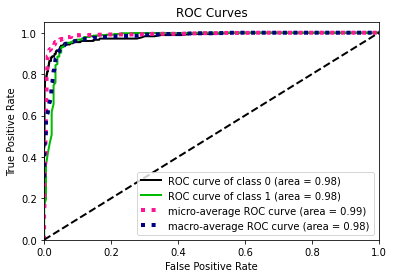

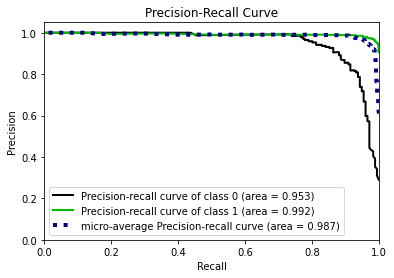

In [ ]:
skplt.metrics.plot_roc(results['labels_8000'],results['proba_8000'])
skplt.metrics.plot_precision_recall(results['labels_8000'],results['proba_8000'])

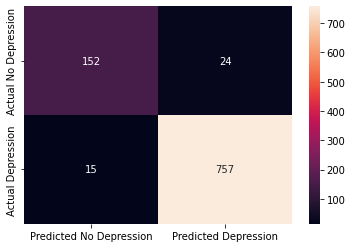

In [ ]:
cm = pd.DataFrame(data=confusion_matrix(results['labels_8000'],
np.argmax(results['proba_8000'],axis=1),
labels=[0,1]),
index=["Actual No Depression", "Actual Depression"],
columns=["Predicted No Depression", "Predicted Depression"])
sns.heatmap(cm,annot=True,fmt="d");

In [ ]:
import shutil
import os
shutil.rmtree('/content/outputs')
shutil.rmtree('/content/runs')
os.remove('/content/args.json')

## XLM

In [ ]:
args = {
    'data_dir': '/content/data/',
    'model_type':  'xlm',
    'model_name': 'xlm-clm-ende-1024',
    'task_name': 'binary',
    'output_dir': 'outputs/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': True,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 20,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Kaggle Mentalhealth dataset'
}
with open('args.json', 'w') as f:
    json.dump(args, f)

if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [ ]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

In [ ]:
config = config_class.from_pretrained(args['model_name'], num_labels=2, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/131 [00:00<?, ?B/s]

In [ ]:
model = model_class.from_pretrained(args['model_name'])

Downloading:   0%|          | 0.00/835M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-clm-ende-1024 were not used when initializing XLMForSequenceClassification: ['pred_layer.proj.weight', 'pred_layer.proj.bias']
- This IS expected if you are initializing XLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMForSequenceClassification were not initialized from the model checkpoint at xlm-clm-ende-1024 and are newly initialized: ['transformer.position_ids', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

In [ ]:
model.to(device);

In [ ]:
task = args['task_name']

processor = processors[task]()
label_list = processor.get_labels()
num_labels = len(label_list)

In [ ]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer)
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

0
3790


100%|██████████| 3790/3790 [00:14<00:00, 268.07it/s]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.amp is deprecated and will be removed by the end of February 2023. Use [PyTorch AMP](https://pytorch.org/docs/stable/amp.html)
  warnings.warn(msg, DeprecatedFeatureWarning)


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.545847Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
0.707373

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:127: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
0.773384Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
1.158666Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
0.641410

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


0.003981

Epoch:   5%|▌         | 1/20 [01:25<27:08, 85.70s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.008792

Epoch:  10%|█         | 2/20 [02:49<25:25, 84.75s/it]

0.029623

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.610032

Epoch:  15%|█▌        | 3/20 [04:14<23:56, 84.52s/it]

0.162950

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000077

Epoch:  20%|██        | 4/20 [05:38<22:29, 84.37s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.916851Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
0.000806

Epoch:  25%|██▌       | 5/20 [07:04<21:16, 85.10s/it]

0.000255

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000086

Epoch:  30%|███       | 6/20 [08:27<19:39, 84.28s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000008

Epoch:  35%|███▌      | 7/20 [09:51<18:14, 84.16s/it]

0.000384

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000005

Epoch:  40%|████      | 8/20 [11:35<18:08, 90.68s/it]

0.000000

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000002

Epoch:  45%|████▌     | 9/20 [13:01<16:21, 89.18s/it]

0.000000

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.649377Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
0.000079

Epoch:  50%|█████     | 10/20 [14:26<14:36, 87.68s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000208

Epoch:  55%|█████▌    | 11/20 [15:50<12:59, 86.64s/it]

0.000110

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000007

Epoch:  60%|██████    | 12/20 [17:13<11:25, 85.65s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.001129

Epoch:  65%|██████▌   | 13/20 [18:38<09:58, 85.46s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000323

Epoch:  70%|███████   | 14/20 [20:01<08:27, 84.62s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.298803Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
0.000001

Epoch:  75%|███████▌  | 15/20 [21:24<07:01, 84.22s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000024

Epoch:  80%|████████  | 16/20 [22:47<05:35, 83.89s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.212926Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
0.000001

Epoch:  85%|████████▌ | 17/20 [24:12<04:12, 84.05s/it]

0.000000

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000000

Epoch:  90%|█████████ | 18/20 [25:35<02:47, 83.83s/it]

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000001

Epoch:  95%|█████████▌| 19/20 [26:58<01:23, 83.55s/it]

0.000000

Iteration:   0%|          | 0/474 [00:00<?, ?it/s]

0.000000

Epoch: 100%|██████████| 20/20 [28:21<00:00, 85.07s/it]

0.000000

In [ ]:
results = {}
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    print("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
        result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
        results.update(result)

Evaluate the following checkpoints: %s ['outputs/checkpoint-2000', 'outputs/checkpoint-4000', 'outputs/checkpoint-6000', 'outputs/checkpoint-8000']
0
948


100%|██████████| 948/948 [00:03<00:00, 264.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:03<00:00, 261.10it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:03<00:00, 259.93it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:03<00:00, 244.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]

0
948


In [ ]:
print(classification_report(results['labels_8000'],
                            np.argmax(results['proba_8000'],axis=1),
                            target_names=['No Depression', 'Depression']))

               precision    recall  f1-score   support

No Depression       0.87      0.84      0.86       176
   Depression       0.96      0.97      0.97       772

     accuracy                           0.95       948
    macro avg       0.92      0.91      0.91       948
 weighted avg       0.95      0.95      0.95       948



In [ ]:
results['mcc_8000']

0.8234303768455651

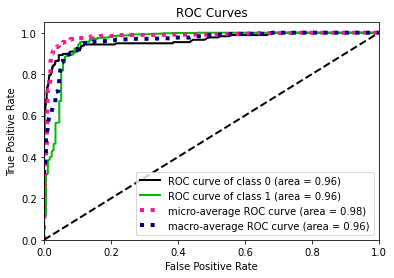

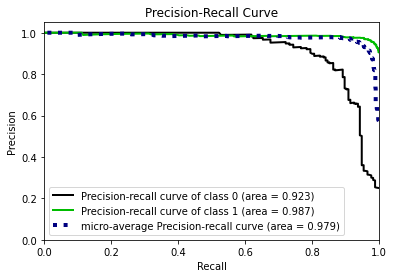

In [ ]:
skplt.metrics.plot_roc(results['labels_8000'],results['proba_8000'])
skplt.metrics.plot_precision_recall(results['labels_8000'],results['proba_8000'])

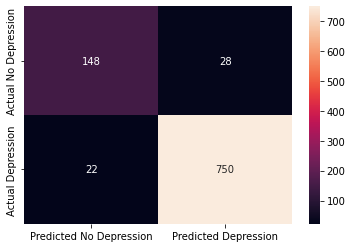

In [ ]:
cm = pd.DataFrame(data=confusion_matrix(results['labels_8000'],
np.argmax(results['proba_8000'],axis=1),
labels=[0,1]),
index=["Actual No Depression", "Actual Depression"],
columns=["Predicted No Depression", "Predicted Depression"])
sns.heatmap(cm,annot=True,fmt="d");

In [ ]:
import shutil
import os
shutil.rmtree('/content/outputs')
shutil.rmtree('/content/runs')
os.remove('/content/args.json')


## RoBERTa

In [ ]:
args = {
    'data_dir': '/content/data/',
    'model_type':  'roberta',
    'model_name': 'roberta-base',
    'task_name': 'binary',
    'output_dir': 'outputs/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': True,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 16,
    'eval_batch_size': 16,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 20,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Kaggle Mentalhealth dataset'
}

In [ ]:
with open('args.json', 'w') as f:
    json.dump(args, f)

if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [ ]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

In [ ]:
config = config_class.from_pretrained(args['model_name'], num_labels=2, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
model = model_class.from_pretrained(args['model_name'])
model.to(device);

task = args['task_name']

processor = processors[task]()
label_list = processor.get_labels()
num_labels = len(label_list)

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer)
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

0
3790


100%|██████████| 3790/3790 [00:09<00:00, 414.23it/s]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.amp is deprecated and will be removed by the end of February 2023. Use [PyTorch AMP](https://pytorch.org/docs/stable/amp.html)
  warnings.warn(msg, DeprecatedFeatureWarning)


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.665306

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:127: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0.411660Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
0.226856Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
0.320004

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


0.401911Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
0.450177Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
0.009307

Epoch:   5%|▌         | 1/20 [01:23<26:19, 83.14s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.477420Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
0.005995

Epoch:  10%|█         | 2/20 [02:37<23:23, 77.99s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000827

Epoch:  15%|█▌        | 3/20 [03:50<21:25, 75.63s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.010093

Epoch:  20%|██        | 4/20 [05:04<20:03, 75.25s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000609

Epoch:  25%|██▌       | 5/20 [06:18<18:39, 74.63s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000308

Epoch:  30%|███       | 6/20 [07:32<17:23, 74.54s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000080

Epoch:  35%|███▌      | 7/20 [08:46<16:03, 74.10s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000055

Epoch:  40%|████      | 8/20 [10:00<14:49, 74.10s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000053

Epoch:  45%|████▌     | 9/20 [11:15<13:38, 74.38s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.001946

Epoch:  50%|█████     | 10/20 [12:28<12:21, 74.16s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000046

Epoch:  55%|█████▌    | 11/20 [13:41<11:03, 73.70s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.205054Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
0.000021

Epoch:  60%|██████    | 12/20 [14:58<09:56, 74.61s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000015

Epoch:  65%|██████▌   | 13/20 [16:10<08:38, 74.05s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000016

Epoch:  70%|███████   | 14/20 [17:24<07:22, 73.80s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000021

Epoch:  75%|███████▌  | 15/20 [18:37<06:07, 73.51s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000011

Epoch:  80%|████████  | 16/20 [19:49<04:52, 73.21s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000011

Epoch:  85%|████████▌ | 17/20 [21:03<03:40, 73.58s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000009

Epoch:  90%|█████████ | 18/20 [22:16<02:26, 73.14s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000011

Epoch:  95%|█████████▌| 19/20 [23:29<01:13, 73.13s/it]

Iteration:   0%|          | 0/237 [00:00<?, ?it/s]

0.000009

Epoch: 100%|██████████| 20/20 [24:42<00:00, 74.11s/it]


In [ ]:
results = {}
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    print("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
        result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
        results.update(result)

Evaluate the following checkpoints: %s ['outputs/checkpoint-2000', 'outputs/checkpoint-4000']
0
948


100%|██████████| 948/948 [00:01<00:00, 498.33it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

0
948
0
948


100%|██████████| 948/948 [00:01<00:00, 504.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

0
948


In [ ]:
results

{'mcc_2000': 0.8643325373008686,
 'tp_2000': 760,
 'tn_2000': 150,
 'fp_2000': 26,
 'fn_2000': 12,
 'labels_2000': array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0

In [ ]:
print(classification_report(results['labels_4000'],
                            np.argmax(results['proba_4000'],axis=1),
                            target_names=['No Depression', 'Depression']))

               precision    recall  f1-score   support

No Depression       0.97      0.81      0.88       176
   Depression       0.96      0.99      0.98       772

     accuracy                           0.96       948
    macro avg       0.96      0.90      0.93       948
 weighted avg       0.96      0.96      0.96       948



In [ ]:
results['mcc_4000']

0.8634490933691913

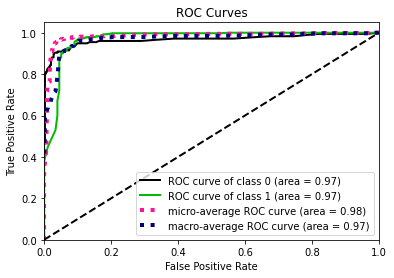

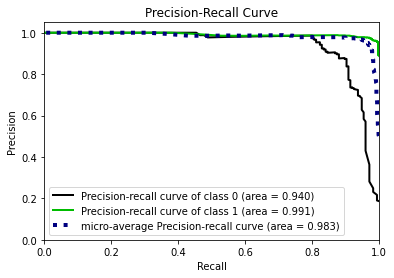

In [ ]:
skplt.metrics.plot_roc(results['labels_4000'],results['proba_4000'])
skplt.metrics.plot_precision_recall(results['labels_4000'],results['proba_4000'])

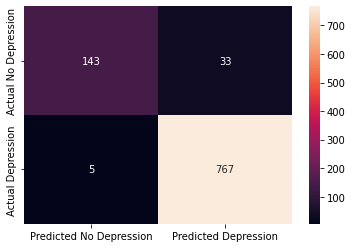

In [ ]:
cm = pd.DataFrame(data=confusion_matrix(results['labels_4000'],
np.argmax(results['proba_4000'],axis=1),
labels=[0,1]),
index=["Actual No Depression", "Actual Depression"],
columns=["Predicted No Depression", "Predicted Depression"])
sns.heatmap(cm,annot=True,fmt="d")

## ElMo

Note: Couldnot run the Model due to Resource limitations

In [ ]:
!pip install tensorflow-hub


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd

elmo = hub.load("https://tfhub.dev/google/elmo/2").signatures["default"]

In [ ]:
train = pd.read_csv('data/train.tsv',sep='\t',header=None,names=['id','label','a','text'])
test = pd.read_csv('data/dev.tsv',sep='\t',header=None,names=['id','label','a','text'])

In [ ]:
# remove URL's from train and test
train['text'] = train['text'].apply(lambda x: re.sub(r'http\S+', '', x))
test['text'] = test['text'].apply(lambda x: re.sub(r'http\S+', '', x))

In [ ]:
# remove punctuation marks
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
train['text'] = train['text'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
test['text'] = test['text'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
# convert text to lowercase
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
# remove numbers
train['text'] = train['text'].str.replace("[0-9]", " ")
test['text'] = test['text'].str.replace("[0-9]", " ")
# remove whitespaces
train['text'] = train['text'].apply(lambda x:' '.join(x.split()))
test['text'] = test['text'].apply(lambda x: ' '.join(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
import spacy
# import spaCy's language model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [ ]:
train['text'] = lemmatization(train['text'])
test['text'] = lemmatization(test['text'])

In [ ]:
train = train.drop(['id','a'],axis=1)
test = test.drop(['id','a'],axis=1)

In [ ]:
train.head()

,label,text
0,0,I feel like I 've win the lottery of life
1,1,before you answer let I tell you a little abou...
2,1,living be just play pretend to I
3,1,my uncle tell my cousin to stay away from I bc...
4,1,I end the relationship with my boyfriend a mon...


In [ ]:
@tf.function
def elmo_vectors(x):
  embeddings = elmo(x)["elmo"]
  return tf.reduce_mean(embeddings,1)

In [ ]:
list_train = [train[i:i+10] for i in range(0,train.shape[0],10)]
list_test = [test[i:i+10] for i in range(0,test.shape[0],10)]

In [ ]:
# Extract ELMo embeddings
elmo_train = [elmo_vectors(x['text']).numpy() for x in list_train]
elmo_test = [elmo_vectors(x['text']).numpy() for x in list_test]

ResourceExhaustedError: ignored

In [ ]:
elmo_train_new = np.concatenate(elmo_train, axis = 0)
elmo_test_new = np.concatenate(elmo_test, axis = 0)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lreg = LogisticRegression()
lreg.fit(xtrain, ytrain)

In [ ]:
preds_test = lreg.predict(elmo_test_new)
